# SQD for water on IBM

In [1]:
import numpy as np
from pathlib import Path

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of

import qiskit
from qiskit_aer import AerSimulator  # For MPS Simulator.

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
HARDWARE: bool = False

In [9]:
ibm_computer: str = "ibm_torino"

if HARDWARE:
    service = qiskit_ibm_runtime.QiskitRuntimeService(name="Q4BIOFLEX")
    computer = service.backend(ibm_computer)
    sampler = Sampler(computer)
else:
    computer = qiskit_ibm_runtime.fake_provider.FakeTorino()
    simulator = AerSimulator(method="matrix_product_state").from_backend(computer)
    sampler = Sampler(simulator)

In [11]:
path = Path("./hamiltonians/qmd/monomer/sampled_20_0.data")

b2a = 1 / 1.8897259886  # Bohr to Angstrom conversion factor.

atom_lines = []
for line in path.read_text().splitlines():
    if line.startswith("atom"):
        atom_lines.append(line)

geometries = []
for i in range(0, len(atom_lines), 3):
    geom = []
    for line in atom_lines[i:i + 3]:
        parts = line.split()
        x, y, z = map(float, parts[1: 3 + 1])
        element = parts[4]
        geom.append((element, (b2a * x, b2a * y, b2a * z)))
    geometries.append(tuple(geom))

assert len(geometries) == 20

In [12]:
geometry = geometries[0]
geometry

(('O', (15.195716819915253, 14.947706561905724, 15.000000000529178)),
 ('H', (15.999716817357, 14.947706561905724, 15.000000000529178)),
 ('H', (14.000283178409584, 15.052293439152633, 15.000000000529178)))

In [13]:
mol = pyscf.gto.Mole()
mol.build(
    atom=geometry,
    basis="sto-6g",
)

In [14]:
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr())

In [15]:
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -75.4707331802862
CASCI E = -75.5161770454358  E(CI) = -84.5737722266063  S^2 = 0.0000000


In [16]:
exact_energy

-75.51617704543584

## Ansatz

In [17]:
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -75.51589223915654  E_corr = -0.04515905887036584


In [18]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister


n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

# Measure all qubits.
circuit.measure_all()

In [19]:
circuit.draw(fold=-1)

┌───────────────────┐┌───────────────────┐ ░ ┌─┐                                       
    q_0: ┤0                  ├┤0                  ├─░─┤M├───────────────────────────────────────
         │                   ││                   │ ░ └╥┘┌─┐                                    
    q_1: ┤1                  ├┤1                  ├─░──╫─┤M├────────────────────────────────────
         │                   ││                   │ ░  ║ └╥┘┌─┐                                 
    q_2: ┤2                  ├┤2                  ├─░──╫──╫─┤M├─────────────────────────────────
         │                   ││                   │ ░  ║  ║ └╥┘┌─┐                              
    q_3: ┤3                  ├┤3                  ├─░──╫──╫──╫─┤M├──────────────────────────────
         │                   ││                   │ ░  ║  ║  ║ └╥┘┌─┐                           
    q_4: ┤4                  ├┤4                  ├─░──╫──╫──╫──╫─┤M├───────────────────────────
         │                   ││                   │ ░  ║  ║  ║  ║ └╥┘┌─┐                        
    q_5: ┤5                  ├┤5                  ├─░──╫──╫──╫──╫──╫─┤M├────────────────────────
         │                   ││                   │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐                     
    q_6: ┤6                  ├┤6                  ├─░──╫──╫──╫──╫──╫──╫─┤M├─────────────────────
         │   Hartree_fock_jw ││   Ucj_balanced_jw │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                  
    q_7: ┤7                  ├┤7                  ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────
         │                   ││                   │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐               
    q_8: ┤8                  ├┤8                  ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────
         │                   ││                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐            
    q_9: ┤9                  ├┤9                  ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────
         │                   ││                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         
   q_10: ┤10                 ├┤10                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────
         │                   ││                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
   q_11: ┤11                 ├┤11                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────
         │                   ││                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
   q_12: ┤12                 ├┤12                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
         │                   ││                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_13: ┤13                 ├┤13                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
         └───────────────────┘└───────────────────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 14/══════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                                                       0  1  2  3  4  5  6  7  8  9  10 11 12 13

## Sample

### Prepare to run on hardware

In [20]:
# initial_layout = list(range(80, 85 + 1)) + list(range(90, 95 + 1)) + list(range(100, 105 + 1)) + list(range(110, 115 + 1))  # Miami Jan 1.
# initial_layout = list(range(3, 7 + 1)) + [16, 17] + list(range(23, 27 + 1))  # Boston Jan 4 before calibration.
# initial_layout = [131, 132, 133, 134, 135, 138, 139, 151, 152, 153, 154, 155]  # Boston Jan 4 before calibration.
initial_layout = [94, 105, 106, 107, 108, 109, 112, 113, 124, 125, 126, 127, 128, 132]

layout_pattern: str = "linear"

if layout_pattern == "staggered":
    spin_a_layout = initial_layout[0::2]
    spin_b_layout = initial_layout[1::2]
elif layout_pattern == "linear":
    spin_a_layout = initial_layout[: len(initial_layout) // 2]
    spin_b_layout = initial_layout[len(initial_layout) // 2:]

In [21]:
len(initial_layout)

14

In [22]:
spin_a_layout

[94, 105, 106, 107, 108, 109, 112]

In [23]:
spin_b_layout

[113, 124, 125, 126, 127, 128, 132]

In [24]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# spin_a_layout = [140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]
# spin_b_layout = [122, 123, 136, 124, 125, 126, 127, 137, 128, 129, 130, 131, 138]
initial_layout = spin_a_layout + spin_b_layout

twoq_best = np.inf
to_run = None
for trial in range(50):
    pass_manager = generate_preset_pass_manager(
        optimization_level=3, backend=computer, initial_layout=initial_layout, seed_transpiler=trial
    )
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    current = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {current.count_ops()}")
    twoq = current.count_ops().get("cz")
    if twoq < twoq_best:
        twoq_best = twoq
        to_run = current

Gate counts (w/ pre-init passes): OrderedDict([('sx', 643), ('rz', 451), ('cz', 248), ('x', 21), ('measure', 14), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 631), ('rz', 453), ('cz', 243), ('x', 23), ('measure', 14), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 627), ('rz', 450), ('cz', 240), ('x', 21), ('measure', 14), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 638), ('rz', 449), ('cz', 248), ('x', 23), ('measure', 14), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 631), ('rz', 453), ('cz', 243), ('x', 23), ('measure', 14), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 631), ('rz', 453), ('cz', 243), ('x', 23), ('measure', 14), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 631), ('rz', 453), ('cz', 243), ('x', 23), ('measure', 14), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('sx', 631), ('rz', 453), ('cz', 243

In [25]:
to_run.count_ops()

OrderedDict([('sx', 627),
             ('rz', 450),
             ('cz', 240),
             ('x', 21),
             ('measure', 14),
             ('barrier', 1)])

In [26]:
# Get the HF state for visualizing results.
q = QuantumRegister(2 * num_orbitals)
hf = QuantumCircuit(q)
hf.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
hf.measure_all()
hf = pass_manager.run(hf)

simulator = AerSimulator(method="matrix_product_state")
result = simulator.run(hf, shots=1)
hf_bitstring = list(result.result().get_counts().keys())[0]
hf_bitstring

'00111110011111'

## Run the circuit

In [27]:
nshots: int = 10_000

### Hardware

In [28]:
job = sampler.run([to_run], shots=nshots)
# job = service.job(job_id="d5bi5nhsmlfc739mh53g")

In [29]:
bit_array = job.result()[0].data.meas

In [30]:
counts = job.result()[0].data.meas.get_counts()

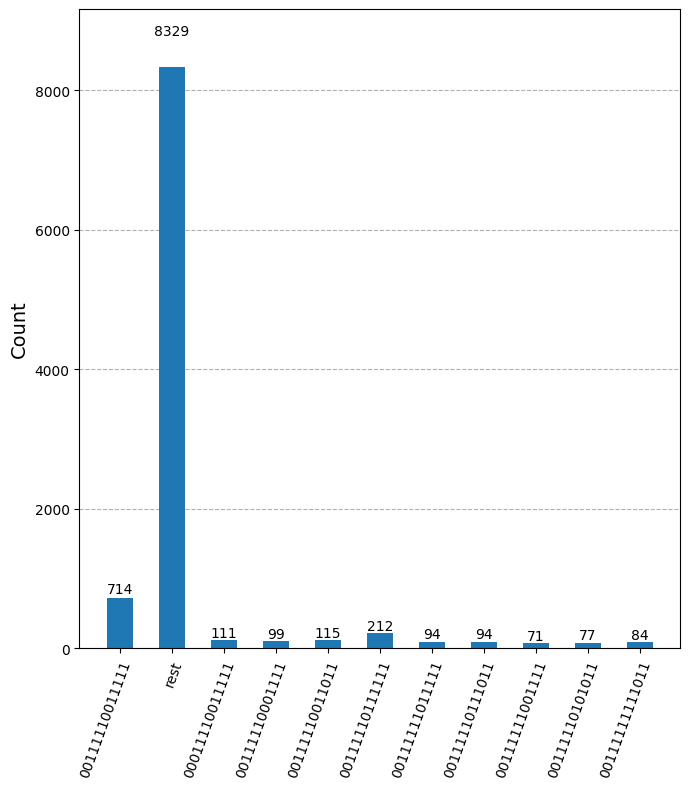

In [31]:
# fig, ax = plt.subplots(figsize=(7, 6))

qiskit.visualization.plot_histogram(
    counts,
    target_string=hf_bitstring,
    sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    # title="HF + UCJ1 on " + computer.name,
    # ax=ax,
    # filename="hf_ucj2.pdf",
)
# plt.tight_layout()
# plt.savefig("hf_ucj1.pdf")

#### MPS simulator

In [ ]:
# simulator = AerSimulator(method="matrix_product_state")

In [ ]:
# result = simulator.run([to_run], shots=nshots)

In [ ]:
# counts = result.result().get_counts()
# counts

In [ ]:
# bit_array = qiskit.primitives.containers.BitArray.from_counts(counts)
# bit_array

#### Uniform random sampling

In [ ]:
# import numpy as np
# from qiskit_addon_sqd.counts import generate_bit_array_uniform

# bit_array = generate_bit_array_uniform(nshots, num_orbitals * 2, rand_seed=1)

## Post-process results

In [32]:
from functools import partial

import numpy as np

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 10
rng = np.random.default_rng(1)

# Eigenstate solver options
num_batches = 2
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -75.5161770454769
		Subspace dimension: 441
	Subsample 1
		Energy: -75.5161770454769
		Subspace dimension: 441
Iteration 2
	Subsample 0
		Energy: -75.5161770454769
		Subspace dimension: 441
	Subsample 1
		Energy: -75.5161770454769
		Subspace dimension: 441


In [33]:
exact_energy

-75.51617704543584

In [34]:
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
min(min_e)

-75.5161770454769

/tmp/ipykernel_22270/1656455523.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "--o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].plot(x1, e_diff, "--o", mec="black", ms=10, alpha=0.75, label=r"$| \Delta E| $", marker="o")


Exact energy: -75.51618 Ha
SQD energy: -75.51618 Ha
Absolute error: 0.00000 Ha


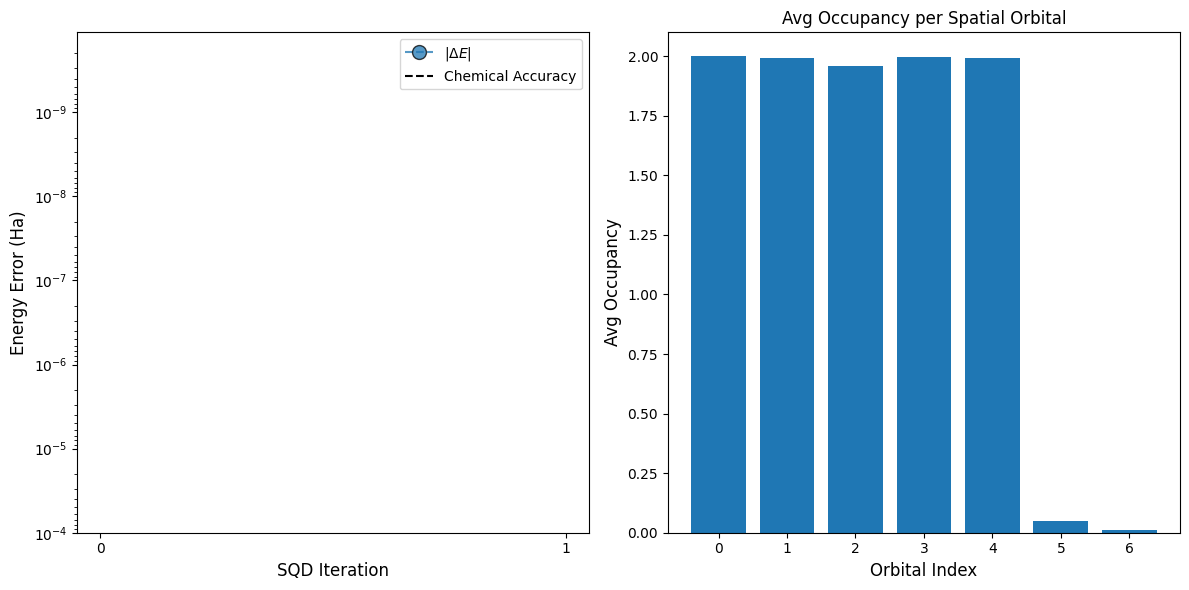

In [35]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, "--o", mec="black", ms=10, alpha=0.75, label=r"$| \Delta E| $", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="black", linestyle="--", label="Chemical Accuracy")
# axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("SQD Iteration", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f} Ha")
print(f"SQD energy: {min_e[-1]:.5f} Ha")
print(f"Absolute error: {e_diff[-1]:.5f} Ha")
plt.tight_layout()
plt.show()